In [1]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.robust.robust_linear_model import RLM
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
# Load the dataset
data = pd.read_csv("C:/Users/nihar/OneDrive/Desktop/Bootcamp/SCMA 632/DataSet/NSSO68.csv", low_memory=False)

In [7]:
# View the first few rows of the dataset
print(data.head())

   slno       grp  Round_Centre  FSU_number  Round  Schedule_Number  Sample  \
0     1  4.10E+31             1       41000     68               10       1   
1     2  4.10E+31             1       41000     68               10       1   
2     3  4.10E+31             1       41000     68               10       1   
3     4  4.10E+31             1       41000     68               10       1   
4     5  4.10E+31             1       41000     68               10       1   

   Sector  state  State_Region  ...  pickle_v  sauce_jam_v  Othrprocessed_v  \
0       2     24           242  ...       0.0          0.0              0.0   
1       2     24           242  ...       0.0          0.0              0.0   
2       2     24           242  ...       0.0          0.0              0.0   
3       2     24           242  ...       0.0          0.0              0.0   
4       2     24           242  ...       0.0          0.0              0.0   

   Beveragestotal_v  foodtotal_v  foodtotal_q  sta

In [9]:
# Check the structure and summary of the data
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101662 entries, 0 to 101661
Columns: 384 entries, slno to fv_tot
dtypes: float64(306), int64(76), object(2)
memory usage: 297.8+ MB
None
               slno  Round_Centre     FSU_number     Round  Schedule_Number  \
count  101662.00000      101662.0  101662.000000  101662.0         101662.0   
mean    50831.50000           1.0   62650.405294      68.0             10.0   
std     29347.43587           0.0   14800.582278       0.0              0.0   
min         1.00000           1.0   41000.000000      68.0             10.0   
25%     25416.25000           1.0   46527.000000      68.0             10.0   
50%     50831.50000           1.0   71793.000000      68.0             10.0   
75%     76246.75000           1.0   75374.000000      68.0             10.0   
max    101662.00000           1.0   79998.000000      68.0             10.0   

         Sample         Sector          state   State_Region       District  \
count  101662.0  10166

In [11]:
# Function to get mode for categorical columns
def get_mode(series):
    return series.mode()[0]

In [13]:
# Replace missing values with median for numeric columns and mode for categorical columns
data = data.apply(lambda x: x.fillna(x.median()) if x.dtype.kind in 'biufc' else x.fillna(get_mode(x)))


In [15]:
# Ensure categorical variables are treated as factors
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype('category')

In [17]:
# Function to cap outliers using the IQR method
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)

In [19]:
# Apply the function to numeric columns
data = data.apply(lambda x: cap_outliers(x) if x.dtype.kind in 'biufc' else x)

In [21]:
# Define the sets of variables
dependent_var1 = "MPCE_URP"
independent_vars1 = ["Age", "Education", "hhdsz", "Social_Group", "Sex"]


In [23]:
# Model 1
if data[dependent_var1].notna().all() and data[independent_vars1].notna().all(axis=1).all():
    formula1 = f"{dependent_var1} ~ {' + '.join(independent_vars1)}"
    model1 = ols(formula1, data=data).fit()
    print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               MPCE_URP   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                 1.178e+04
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:19:50   Log-Likelihood:            -8.3298e+05
No. Observations:              101662   AIC:                         1.666e+06
Df Residuals:                  101657   BIC:                         1.666e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      539.3806      6.423     83.975   

Text(0, 0.5, 'Residuals')

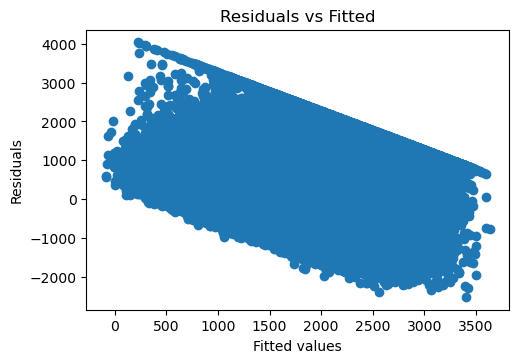

In [27]:
# Diagnostic plots for model1
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(model1.fittedvalues, model1.resid)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Text(0.5, 1.0, 'Histogram of residuals')

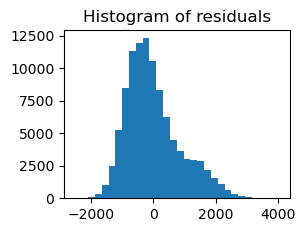

In [29]:
plt.subplot(2, 2, 2)
plt.hist(model1.resid, bins=30)
plt.title('Histogram of residuals')

Text(0.5, 1.0, 'QQ plot')

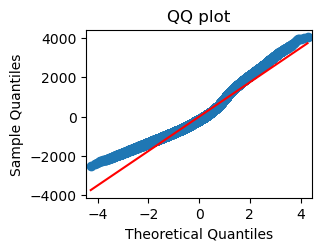

In [31]:
plt.subplot(2, 2, 3)
sm.qqplot(model1.resid, line='s', ax=plt.gca())
plt.title('QQ plot')

Text(0, 0.5, 'Actual values')

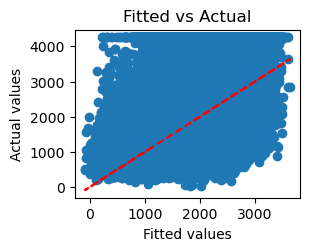

In [33]:
plt.subplot(2, 2, 4)
plt.plot(model1.fittedvalues, model1.fittedvalues, 'r--')
plt.scatter(model1.fittedvalues, data[dependent_var1])
plt.title('Fitted vs Actual')
plt.xlabel('Fitted values')
plt.ylabel('Actual values')

In [39]:
# Identify aliased coefficients in the model
aliased_coefs = model1.params[model1.params.isna()].index.tolist()

In [41]:
# Remove aliased variables from the list of independent variables
independent_vars1 = [var for var in independent_vars1 if var not in aliased_coefs]


In [43]:
# Refit the model without the aliased variables
formula1 = f"{dependent_var1} ~ {' + '.join(independent_vars1)}"
model1 = ols(formula1, data=data).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               MPCE_URP   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                 1.178e+04
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:26:05   Log-Likelihood:            -8.3298e+05
No. Observations:              101662   AIC:                         1.666e+06
Df Residuals:                  101657   BIC:                         1.666e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      539.3806      6.423     83.975   

In [49]:
# Check for multicollinearity in the refitted model
X1 = data[independent_vars1].copy()
X1['intercept'] = 1

In [51]:
# Check for zero variance columns
zero_variance_cols = [col for col in X1.columns if X1[col].var() == 0]


In [53]:
# Remove zero variance columns
X1 = X1.drop(columns=zero_variance_cols)

In [55]:
# Calculate VIF
vif_df1 = pd.DataFrame()
vif_df1["VIF Factor"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif_df1["features"] = X1.columns
print(vif_df1)

   VIF Factor      features
0    7.218980           Age
1    3.347385     Education
2    5.259796         hhdsz
3    3.108340  Social_Group


In [57]:
# Transform the dependent variable if necessary
data['log_MPCE_URP'] = np.log(data[dependent_var1])

In [59]:
# Fit robust regression model
formula1_robust = f"log_MPCE_URP ~ {' + '.join(independent_vars1)}"
model1_robust = RLM.from_formula(formula1_robust, data=data).fit()
print(model1_robust.summary())


                    Robust linear Model Regression Results                    
Dep. Variable:           log_MPCE_URP   No. Observations:               101662
Model:                            RLM   Df Residuals:                   101657
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 23 Jun 2024                                         
Time:                        21:29:14                                         
No. Iterations:                    18                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.4573      0.004    977.711   

Text(0, 0.5, 'Residuals')

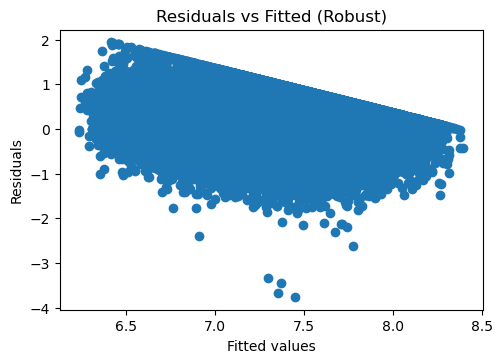

In [61]:
# Diagnostic plots for the robust regression model
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(model1_robust.fittedvalues, model1_robust.resid)
plt.title('Residuals vs Fitted (Robust)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Text(0.5, 1.0, 'Histogram of residuals (Robust)')

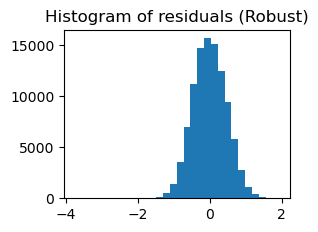

In [63]:
plt.subplot(2, 2, 2)
plt.hist(model1_robust.resid, bins=30)
plt.title('Histogram of residuals (Robust)')

Text(0.5, 1.0, 'QQ plot (Robust)')

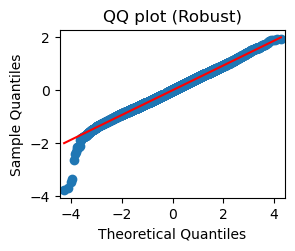

In [65]:
plt.subplot(2, 2, 3)
sm.qqplot(model1_robust.resid, line='s', ax=plt.gca())
plt.title('QQ plot (Robust)')

Text(0, 0.5, 'Actual values')

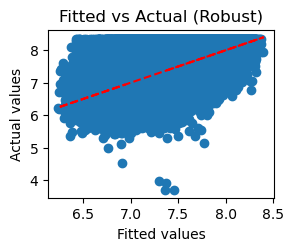

In [67]:
plt.subplot(2, 2, 4)
plt.plot(model1_robust.fittedvalues, model1_robust.fittedvalues, 'r--')
plt.scatter(model1_robust.fittedvalues, data['log_MPCE_URP'])
plt.title('Fitted vs Actual (Robust)')
plt.xlabel('Fitted values')
plt.ylabel('Actual values')


In [69]:
# Generate predictions using the robust regression model
predictions1 = model1_robust.predict(data)

In [71]:
# Validate the model using a train-test split
train_data, test_data = train_test_split(data, test_size=0.3, random_state=123)
model1_robust_train = RLM.from_formula(formula1_robust, data=train_data).fit()


In [73]:
# Predict on the test data
predictions_test1 = model1_robust_train.predict(test_data)

In [75]:
# Evaluate model performance on the test data
actuals_test1 = np.log(test_data[dependent_var1])
rmse1 = np.sqrt(mean_squared_error(actuals_test1, predictions_test1))
print(f"RMSE on test data: {rmse1}")

RMSE on test data: 0.4683373602986067


In [77]:
# Interpretation of the model coefficients
print(model1_robust.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:           log_MPCE_URP   No. Observations:               101662
Model:                            RLM   Df Residuals:                   101657
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 23 Jun 2024                                         
Time:                        21:30:44                                         
No. Iterations:                    18                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.4573      0.004    977.711   

In [79]:
# Define the sets of variables for Model 2 and Model 3
dependent_var2 = "MPCE_MRP"
independent_vars2 = ["HH_type", "Religion", "Whether_owns_any_land", "Regular_salary_earner", "Meals_At_Home"]

In [81]:
# Model 2
if data[dependent_var2].notna().all() and data[independent_vars2].notna().all(axis=1).all():
    formula2 = f"{dependent_var2} ~ {' + '.join(independent_vars2)}"
    model2 = ols(formula2, data=data).fit()
    print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:               MPCE_MRP   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     3029.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:31:23   Log-Likelihood:            -8.5125e+05
No. Observations:              101662   AIC:                         1.703e+06
Df Residuals:                  101658   BIC:                         1.703e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1067.67

Text(0, 0.5, 'Residuals')

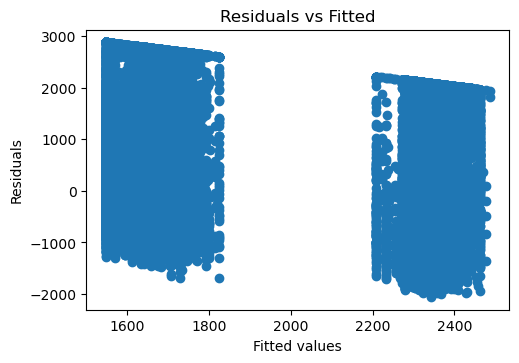

In [85]:
 # Diagnostic plots for model2
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(model2.fittedvalues, model2.resid)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Text(0.5, 1.0, 'Histogram of residuals')

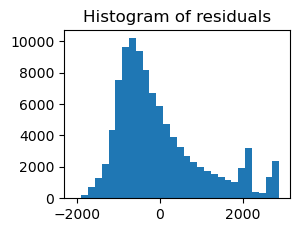

In [87]:
plt.subplot(2, 2, 2)
plt.hist(model2.resid, bins=30)
plt.title('Histogram of residuals')

Text(0.5, 1.0, 'QQ plot')

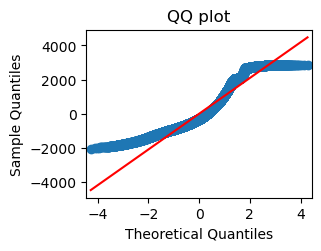

In [89]:
plt.subplot(2, 2, 3)
sm.qqplot(model2.resid, line='s', ax=plt.gca())
plt.title('QQ plot')

Text(0, 0.5, 'Actual values')

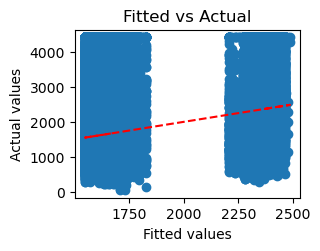

In [91]:
plt.subplot(2, 2, 4)
plt.plot(model2.fittedvalues, model2.fittedvalues, 'r--')
plt.scatter(model2.fittedvalues, data[dependent_var2])
plt.title('Fitted vs Actual')
plt.xlabel('Fitted values')
plt.ylabel('Actual values')

In [95]:
# Identify aliased coefficients in the model
aliased_coefs2 = model2.params[model2.params.isna()].index.tolist()

In [99]:
# Remove aliased variables from the list of independent variables
independent_vars2 = [var for var in independent_vars2 if var not in aliased_coefs2]


In [101]:
 # Refit the model without the aliased variables
formula2 = f"{dependent_var2} ~ {' + '.join(independent_vars2)}"
model2 = ols(formula2, data=data).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:               MPCE_MRP   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     3029.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:34:04   Log-Likelihood:            -8.5125e+05
No. Observations:              101662   AIC:                         1.703e+06
Df Residuals:                  101658   BIC:                         1.703e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1067.67

In [103]:
# Check for multicollinearity in the refitted model
X2 = data[independent_vars2].copy()
X2['intercept'] = 1

In [105]:
# Check for zero variance columns and remove them
zero_variance_cols2 = [col for col in X2.columns if X2[col].var() == 0]
X2 = X2.drop(columns=zero_variance_cols2)

In [107]:
vif_df2 = pd.DataFrame()
vif_df2["VIF Factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif_df2["features"] = X2.columns
print(vif_df2)

   VIF Factor               features
0    3.395658                HH_type
1    9.861331  Regular_salary_earner
2   10.066748          Meals_At_Home


In [109]:
# Transform the dependent variable if necessary
data['log_MPCE_MRP'] = np.log(data[dependent_var2])

In [111]:
# Fit robust regression model
formula2_robust = f"log_MPCE_MRP ~ {' + '.join(independent_vars2)}"
model2_robust = RLM.from_formula(formula2_robust, data=data).fit()
print(model2_robust.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:           log_MPCE_MRP   No. Observations:               101662
Model:                            RLM   Df Residuals:                   101658
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 23 Jun 2024                                         
Time:                        21:36:59                                         
No. Iterations:                    24                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.71

Text(0, 0.5, 'Residuals')

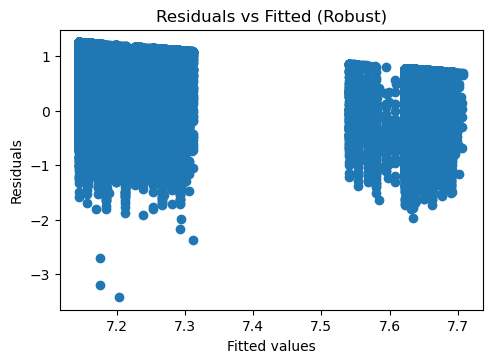

In [113]:
 # Diagnostic plots for the robust regression model
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(model2_robust.fittedvalues, model2_robust.resid)
plt.title('Residuals vs Fitted (Robust)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')


Text(0.5, 1.0, 'Histogram of residuals (Robust)')

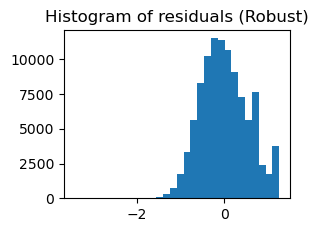

In [115]:
plt.subplot(2, 2, 2)
plt.hist(model2_robust.resid, bins=30)
plt.title('Histogram of residuals (Robust)')

Text(0.5, 1.0, 'QQ plot (Robust)')

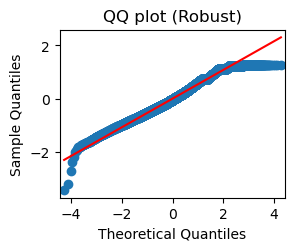

In [117]:
plt.subplot(2, 2, 3)
sm.qqplot(model2_robust.resid, line='s', ax=plt.gca())
plt.title('QQ plot (Robust)')

Text(0, 0.5, 'Actual values')

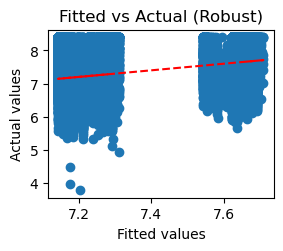

In [123]:
plt.subplot(2, 2, 4)
plt.plot(model2_robust.fittedvalues, model2_robust.fittedvalues, 'r--')
plt.scatter(model2_robust.fittedvalues, data['log_MPCE_MRP'])
plt.title('Fitted vs Actual (Robust)')
plt.xlabel('Fitted values')
plt.ylabel('Actual values')

In [127]:
# Generate predictions using the robust regression model
predictions2 = model2_robust.predict(data)


In [129]:
# Validate the model using a train-test split
train_data2, test_data2 = train_test_split(data, test_size=0.3, random_state=123)
model2_robust_train = RLM.from_formula(formula2_robust, data=train_data2).fit()


In [131]:
# Predict on the test data
predictions_test2 = model2_robust_train.predict(test_data2)


In [133]:
# Evaluate model performance on the test data
actuals_test2 = np.log(test_data2[dependent_var2])
rmse2 = np.sqrt(mean_squared_error(actuals_test2, predictions_test2))
print(f"RMSE on test data: {rmse2}")


RMSE on test data: 0.5381046935680763


In [135]:
# Interpretation of the model coefficients
print(model2_robust.summary())


                    Robust linear Model Regression Results                    
Dep. Variable:           log_MPCE_MRP   No. Observations:               101662
Model:                            RLM   Df Residuals:                   101658
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 23 Jun 2024                                         
Time:                        21:39:48                                         
No. Iterations:                    24                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.71

In [137]:
# Define the sets of variables for Model 3
dependent_var3 = "MPCE_URP"
independent_vars3 = ["Land_Total_possessed", "Land_Owned", "Cooking_code", "Lighting_code", "Dwelling_unit_code"]


In [139]:
# Model 3
if data[dependent_var3].notna().all() and data[independent_vars3].notna().all(axis=1).all():
    formula3 = f"{dependent_var3} ~ {' + '.join(independent_vars3)}"
    model3 = ols(formula3, data=data).fit()
    print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:               MPCE_URP   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2823.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:40:46   Log-Likelihood:            -8.4827e+05
No. Observations:              101662   AIC:                         1.697e+06
Df Residuals:                  101658   BIC:                         1.697e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               34.7585 

Text(0, 0.5, 'Residuals')

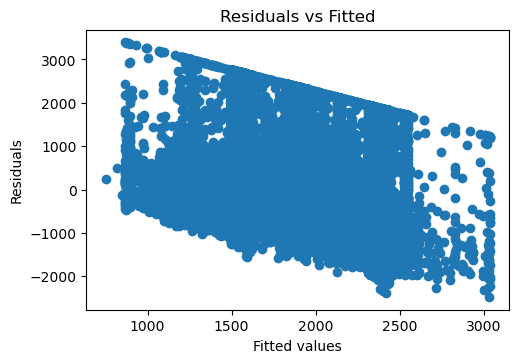

In [143]:
# Diagnostic plots for model3
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(model3.fittedvalues, model3.resid)
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')


Text(0.5, 1.0, 'Histogram of residuals')

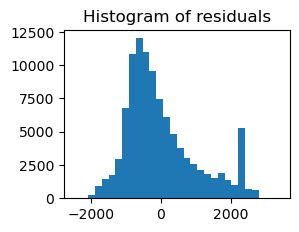

In [145]:
plt.subplot(2, 2, 2)
plt.hist(model3.resid, bins=30)
plt.title('Histogram of residuals')

Text(0.5, 1.0, 'QQ plot')

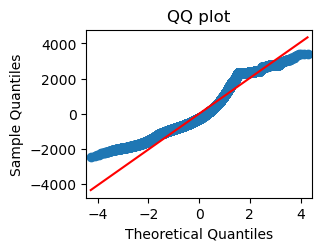

In [147]:
plt.subplot(2, 2, 3)
sm.qqplot(model3.resid, line='s', ax=plt.gca())
plt.title('QQ plot')

Text(0, 0.5, 'Actual values')

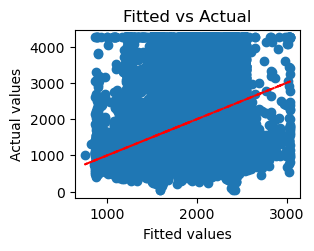

In [149]:
plt.subplot(2, 2, 4)
plt.plot(model3.fittedvalues, model3.fittedvalues, 'r--')
plt.scatter(model3.fittedvalues, data[dependent_var3])
plt.title('Fitted vs Actual')
plt.xlabel('Fitted values')
plt.ylabel('Actual values')

In [151]:
# Identify aliased coefficients in the model
aliased_coefs3 = model3.params[model3.params.isna()].index.tolist()

In [153]:
# Remove aliased variables from the list of independent variables
independent_vars3 = [var for var in independent_vars3 if var not in aliased_coefs3]


In [155]:
# Refit the model without the aliased variables
formula3 = f"{dependent_var3} ~ {' + '.join(independent_vars3)}"
model3 = ols(formula3, data=data).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:               MPCE_URP   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2823.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:43:10   Log-Likelihood:            -8.4827e+05
No. Observations:              101662   AIC:                         1.697e+06
Df Residuals:                  101658   BIC:                         1.697e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               34.7585 

In [157]:
# Check for multicollinearity in the refitted model
X3 = data[independent_vars3].copy()
X3['intercept'] = 1

In [159]:
# Check for zero variance columns and remove them
zero_variance_cols3 = [col for col in X3.columns if X3[col].var() == 0]
X3 = X3.drop(columns=zero_variance_cols3)

In [161]:
vif_df3 = pd.DataFrame()
vif_df3["VIF Factor"] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
vif_df3["features"] = X3.columns
print(vif_df3)


   VIF Factor              features
0    9.883224  Land_Total_possessed
1   10.182281            Land_Owned
2    1.391501          Cooking_code


In [163]:
# Transform the dependent variable if necessary
data['log_MPCE_URP3'] = np.log(data[dependent_var3])

In [165]:
# Fit robust regression model
formula3_robust = f"log_MPCE_URP ~ {' + '.join(independent_vars3)}"
model3_robust = RLM.from_formula(formula3_robust, data=data).fit()
print(model3_robust.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:           log_MPCE_URP   No. Observations:               101662
Model:                            RLM   Df Residuals:                   101658
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 23 Jun 2024                                         
Time:                        21:44:10                                         
No. Iterations:                    22                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2515 

Text(0, 0.5, 'Residuals')

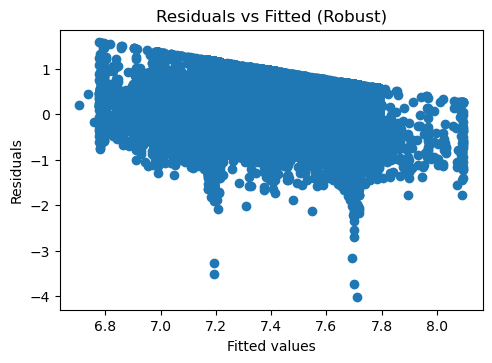

In [169]:
# Diagnostic plots for the robust regression model
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(model3_robust.fittedvalues, model3_robust.resid)
plt.title('Residuals vs Fitted (Robust)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Text(0.5, 1.0, 'Histogram of residuals (Robust)')

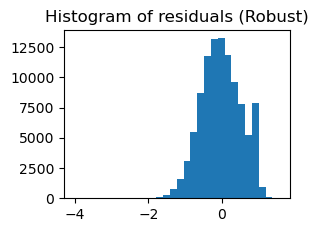

In [171]:
plt.subplot(2, 2, 2)
plt.hist(model3_robust.resid, bins=30)
plt.title('Histogram of residuals (Robust)')

Text(0.5, 1.0, 'QQ plot (Robust)')

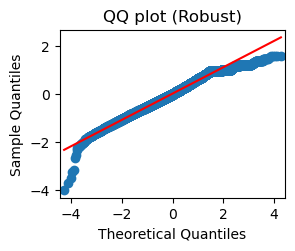

In [173]:
plt.subplot(2, 2, 3)
sm.qqplot(model3_robust.resid, line='s', ax=plt.gca())
plt.title('QQ plot (Robust)')

Text(0, 0.5, 'Actual values')

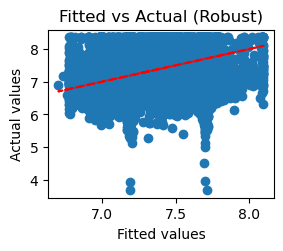

In [175]:
plt.subplot(2, 2, 4)
plt.plot(model3_robust.fittedvalues, model3_robust.fittedvalues, 'r--')
plt.scatter(model3_robust.fittedvalues, data['log_MPCE_URP3'])
plt.title('Fitted vs Actual (Robust)')
plt.xlabel('Fitted values')
plt.ylabel('Actual values')

In [177]:
# Generate predictions using the robust regression model
predictions3 = model3_robust.predict(data)

In [179]:
# Validate the model using a train-test split
train_data3, test_data3 = train_test_split(data, test_size=0.3, random_state=123)
model3_robust_train = RLM.from_formula(formula3_robust, data=train_data3).fit()


In [181]:
# Predict on the test data
predictions_test3 = model3_robust_train.predict(test_data3)

In [183]:
# Evaluate model performance on the test data
actuals_test3 = np.log(test_data3[dependent_var3])
rmse3 = np.sqrt(mean_squared_error(actuals_test3, predictions_test3))
print(f"RMSE on test data: {rmse3}")

RMSE on test data: 0.5512732700917877


In [185]:
# Interpretation of the model coefficients
print(model3_robust.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:           log_MPCE_URP   No. Observations:               101662
Model:                            RLM   Df Residuals:                   101658
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 23 Jun 2024                                         
Time:                        21:46:28                                         
No. Iterations:                    22                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2515 